In [1]:
import gym
import time
import torch
from torch import nn
import numpy as np
import copy
import random as rd
import matplotlib.pyplot as plt

from agent import Agent
from net import DeepQNet
from train import train

# Understanding the environment

In [2]:
env = gym.make('CartPole-v0')
env.reset()

for i_episode in range(1):
    observation = env.reset()
    for t in range(500):
        time.sleep(1)
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 61 timesteps


In [16]:
env.action_space

Discrete(2)

In [17]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [18]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

# Deep Q Network

> https://towardsdatascience.com/qrash-course-deep-q-networks-from-the-ground-up-1bbda41d3677

> https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

In [19]:
net = DeepQNet()
agent = Agent(net, env)
print(net)

DeepQNet(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=24, bias=True)
    (1): Tanh()
    (2): Linear(in_features=24, out_features=2, bias=True)
  )
)


Mean score over 50 last episodes: 19
Mean score over 50 last episodes: 22
Average Loss: 0.3326696466654539
Mean score over 50 last episodes: 21
Mean score over 50 last episodes: 38
Average Loss: 0.4146488794311881
Mean score over 50 last episodes: 39
Mean score over 50 last episodes: 48
Average Loss: 0.4738894420932047
Mean score over 50 last episodes: 79
Mean score over 50 last episodes: 79
Average Loss: 0.5112393819959834
Mean score over 50 last episodes: 156
Mean score over 50 last episodes: 233
Average Loss: 0.5347080463211751
Mean score over 50 last episodes: 210
Mean score over 50 last episodes: 281
Average Loss: 0.5510730538170902
Mean score over 50 last episodes: 245
Mean score over 50 last episodes: 206
Average Loss: 0.5657179645512952
Mean score over 50 last episodes: 350
Mean score over 50 last episodes: 321
Average Loss: 0.5746236587213934
Mean score over 50 last episodes: 319
Mean score over 50 last episodes: 299
Average Loss: 0.5803396662331943
Mean score over 50 last epi

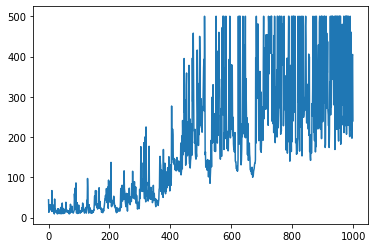

In [20]:
agent = train(n_episodes=2000, n_steps_max=2000, print_ever_k_episodes=50)

In [22]:
env = gym.make('CartPole-v1')
env.reset()

for i_episode in range(1):
    observation = env.reset()
    for t in range(1000):
        time.sleep(0.02)
        env.render()
        action = agent.act(observation, 500)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 500 timesteps


# Pistes

> Implémenter UCB plutôt qu'epsilon greedy

> Hyperoptimisation (learning rate, architecture, epsilon, discount)

> Plus d'épisodes